# Analysis of Austin Waste Dataset 🗑

## 1. EDA 🔎

---

First, we are going to take a first dive into the data in order to get a feeling of what we are dealing with.

In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from scipy import stats
import math

In [3]:
# Mount google drive. Make sure the waste dataset is uploaded to your cloud in csv format
from google.colab import drive
drive.mount("/content/drive")

# Eventually, adapt path to dataset
df_path = "drive/MyDrive/waste_collection.csv"

Mounted at /content/drive


In [4]:
# Load the dataset and take a first peak
df = pd.read_csv(df_path)
df.head()

,Report Date,Load Type,Load Time,Load Weight,Dropoff Site,Route Type,Route Number,Load ID
0,12/8/2020,BULK,12/8/2020 15:02,5220.0,TDS LANDFILL,BULK,BU13,899097
1,12/8/2020,RECYCLING - SINGLE STREAM,12/8/2020 10:00,11140.0,TDS - MRF,RECYCLING - SINGLE STREAM,RTAU53,899078
2,12/3/2020,RECYCLING - SINGLE STREAM,12/3/2020 10:34,10060.0,BALCONES RECYCLING,RECYCLING - SINGLE STREAM,RHBU10,899082
3,12/7/2020,SWEEPING,12/7/2020 10:15,7100.0,TDS LANDFILL,SWEEPER DUMPSITES,DSS04,899030
4,12/7/2020,RECYCLING - SINGLE STREAM,12/7/2020 16:00,12000.0,TDS - MRF,RECYCLING - SINGLE STREAM,RMAU53,899048


In [5]:
pd.options.display.float_format = "{:.2f}".format
df['Load Weight'].describe()

count    668538.00
mean      11763.48
std        7554.86
min       -4480.00
25%        5740.00
50%       11020.00
75%       16520.00
max     1562821.00
Name: Load Weight, dtype: float64

The `Load Weight` is in pounds. It is odd that its minimum is below 0. The maximum is also quite high: 1 562 821 pounds! 🤯 Apart from that, Austin produces quite a lot of waste: the median value is about 11 020 pounds 😶


In [6]:
df.dtypes

Report Date      object
Load Type        object
Load Time        object
Load Weight     float64
Dropoff Site     object
Route Type       object
Route Number     object
Load ID           int64
dtype: object

Seems like we are only dealing with categorical variables, whereas our target is continous. We are all set for a Regression task. ⚡

In [7]:
df.isna().sum()

Report Date         0
Load Type           0
Load Time           0
Load Weight     72335
Dropoff Site        0
Route Type          0
Route Number        0
Load ID             0
dtype: int64

In [8]:
df.isna().sum() / len(df)

Report Date    0.00
Load Type      0.00
Load Time      0.00
Load Weight    0.10
Dropoff Site   0.00
Route Type     0.00
Route Number   0.00
Load ID        0.00
dtype: float64

In [9]:
size = df.size
less_than_zero_or_null = len([val for val in df["Load Weight"] if val <= 0 or pd.isnull(val)])
less_than_zero = len([val for val in df["Load Weight"] if val < 0])
statement = f"{less_than_zero_or_null} observations of Loss Weight are either zero or null. {less_than_zero} out of {size} values are negative."
print(statement)

72624 observations of Loss Weight are either zero or null. 1 out of 5926984 values are negative.


We have some missing values in our target variable, ` Load Weight`. Furtherore, there are some negative weights that we need to exclude in our model. Let's get a better understanding by creating some plots. Before, we exclude those values. ⏩

In [10]:
df.dropna(how="any", inplace = True)
df = df[df["Load Weight"] >= 0]

In [11]:
def get_boxplot(cat_column: str, k: int=10) -> plt.Axes:
    """Function that returns a boxplot of the passed categorical column.
    It only consideres the top k categories,

    :param cat_column: categorical column
    :type cat_column: str
    :param k: upper boundary for categories to consider
    :type k: int
    :return: boxplot
    :rtype: plt.Axes
    """
    top_10_categories = df[cat_column].value_counts()[:k]
    cat_column_transformed = [val if val in top_10_categories else "Other" for val in df[cat_column]]
    sns.set_theme(style="whitegrid")
    ax = sns.boxplot(cat_column_transformed, df["Load Weight"])
    ax.set_ylim(-1000,40000)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_title(f"Boxplot of {cat_column} and Load Weight")
    return ax

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


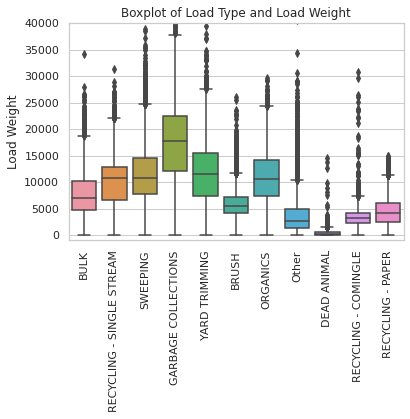

In [12]:
ax = get_boxplot("Load Type")

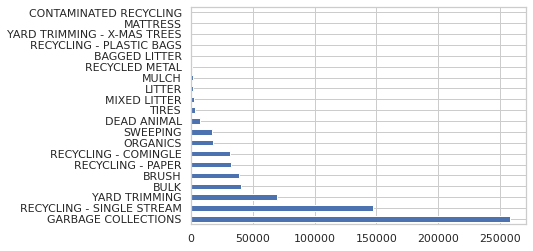

In [13]:
df["Load Type"].value_counts()[:20].plot(kind='barh')

As expected, regular garbage collections, single stream recycling, and yard trimmings are the most prominent types of loads in the dataset, making up about ~72% of the target variables. 

> Single-stream (also known as “fully commingled” or "single-sort") recycling refers to a system in which all paper fibers, plastics, metals, and other containers are mixed in a collection truck, instead of being sorted by the depositor into separate commodities (newspaper, paperboard, corrugated fiberboard, plastic, glass, etc.) and handled separately throughout the collection process. **[Source: Wikipedia]**

Most of the waste is associated to the `Load Type` `GARBAGE COLLECTIONS`. But `RECYCLING - SINGLE STREAM` is getting there! *💪*

What about the type of dropoff sites? Where does our trash end up?

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


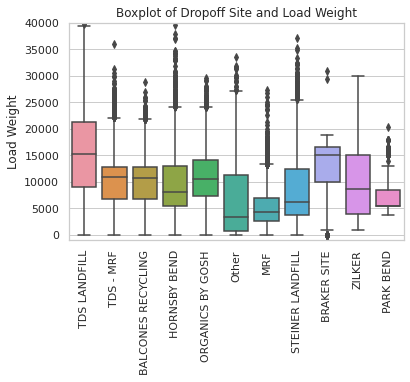

In [14]:
ax = get_boxplot("Dropoff Site")

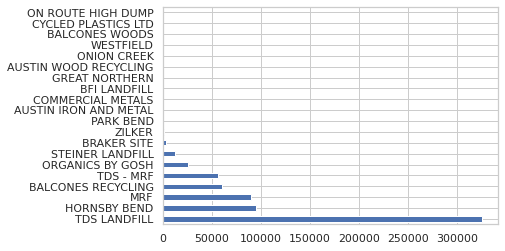

In [15]:
df["Dropoff Site"].value_counts()[:20].plot(kind='barh')

`TDS LANDFILL` is by far the biggest dropoff site (TDS stands for Texas Disposal Systems). That is not a surprise since it is one of the largest solid waste collection, processing and disposal companies in the United States. 👥

See [this link](https://www.texasdisposal.com/processing/austin-landfill/) for more information:
>Located on 2,000 acres of land, Texas Landfill Management (TLM)’s southeast Travis County facility was opened on Feb. 1, 1991. The facility incorporates solid waste disposal, materials processing, compost production, and recycling operations, processing on average between 3,000 and 4,000 tons of solid waste per day.

Hornsby Bend at number 2 is a biowaste management plant.
>TDS Austin and Travis County residents can drop yard trimmings and large brush at the Hornsby Bend Biosolids Management Plant (2210 FM 973, Austin, Texas) [Source](https://www.austintexas.gov/brushdropoff#:~:text=Austin%20and%20Travis%20County%20residents,30%20p.m.%2C%20Monday%20%E2%80%93%20Saturday.)


MRF stands for Materials Recovery Facility. It's a special type of dropoff site from the TDS. Click [here](https://www.texasdisposal.com/) for more information.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


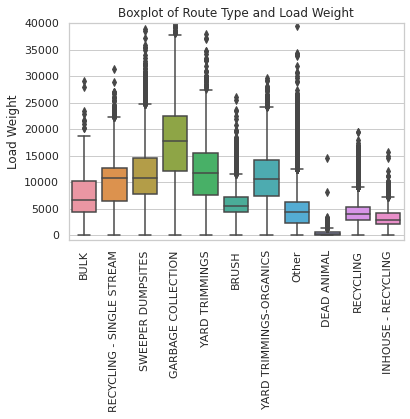

In [16]:
ax = get_boxplot("Route Type")

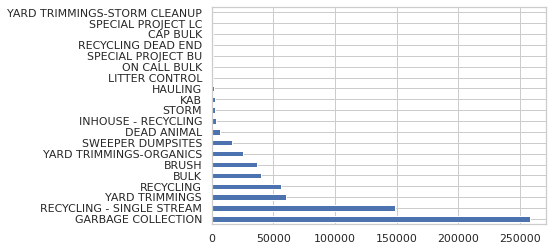

In [17]:
df["Route Type"].value_counts()[:20].plot(kind='barh')

Route types are the general categories of collection service provided by Austin Resource Recovery. We will not go into the details as a good look into the Load Types can be found a few cells above.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


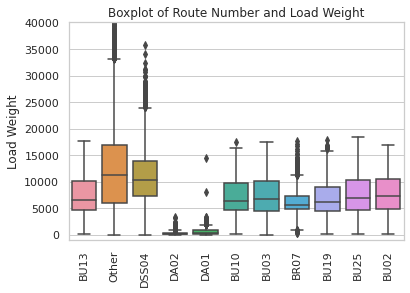

In [18]:
ax = get_boxplot("Route Number")

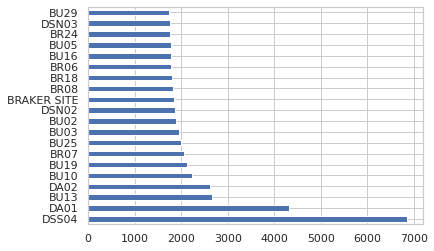

In [19]:
df["Route Number"].value_counts()[:20].plot(kind='barh')

Route numbers can be confusing, right? Better take a look at this [map](https://www.austintexas.gov/sites/default/files/files/Trash_and_Recycling/PAYT_22x34_2012.pdf) provided the government of Austin. 🗾

### Load Type vs. Route Type vs. Route Number
Generally, one load type can have multiple route types, whereas one route number is associated to exactly one route type. Let's take a closer look at `GARBAGE COLLECTIONS`, the most common load type.

In [20]:
df[df["Load Type"] == "GARBAGE COLLECTIONS"]["Route Type"].value_counts()

GARBAGE COLLECTION           258331
SPECIAL EVENTS                   13
YARD TRIMMINGS                   13
RECYCLING - SINGLE STREAM        11
KAB                               8
SPECIAL PROJECT LC                6
YARD TRIMMINGS-ORGANICS           4
ALLEY BULK REMOVAL                3
LITTER CONTROL                    2
RECYCLING                         2
DEAD ANIMAL                       1
BRUSH                             1
Name: Route Type, dtype: int64

We can see that the most common `Route Type` of `GARBAGE COLLECTIONS` is `GARBAGE COLLECTIONS` as well. It is linked to over 400 `Route Numbers`. 🚗

In [21]:
df[df["Route Type"] == "GARBAGE COLLECTION"]["Route Number"].value_counts()

PAM72       1707
PAM74       1673
PAM73       1670
PAM71       1663
PAM01       1659
            ... 
FNONJM00       1
PH99           1
PW87           1
MNONCG         1
WNONGL         1
Name: Route Number, Length: 432, dtype: int64

`PAM72` is a small area in the South of Austin. Garbage day is Monday. 😀

In [22]:
routes = df.groupby("Route Number")
routes_by_route_type = routes["Route Type"].nunique()
routes_by_load_type = routes["Load Type"].nunique()
print(f"Redundant Route Types: {(routes_by_route_type > 1).sum()}")
print(f"Redundant Load Types: {(routes_by_load_type > 1).sum()}")

Redundant Route Types: 0
Redundant Load Types: 708


### Time series
---
It is also interesting to look at the data from a time series perspective ⏲.
For instance, garbage collection is scheduled differently according to the individual districts. Also, organic waste may vary over the year ❄ 🌞

In [23]:
df_ts = df.copy()
df_ts["Load Time"] = pd.to_datetime(df_ts["Load Time"])
df_ts = df_ts.sort_values("Load Time")
df_ts.set_index("Load Time", inplace=True)
df_ts.head()

,Report Date,Load Type,Load Weight,Dropoff Site,Route Type,Route Number,Load ID
Load Time,,,,,,,
2000-01-26 12:39:00,1/26/2006,RECYCLING - PAPER,2940.00,MRF,RECYCLING,RH12,163262
2001-03-16 09:38:00,3/16/2012,BULK,4240.00,TDS LANDFILL,BULK,BU05,522335
2001-03-16 13:33:00,3/16/2012,BULK,4740.00,TDS LANDFILL,BULK,BU05,522334
2001-10-16 11:51:00,10/16/2012,BULK,14080.00,TDS LANDFILL,BULK,BU16,545997
2001-10-16 15:28:00,10/16/2012,BULK,8260.00,TDS LANDFILL,BULK,BU16,545996


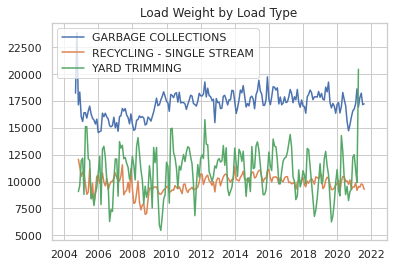

In [24]:
for load_type in df["Load Type"].value_counts()[:3].index:
  tmp = df_ts[df_ts["Load Type"] == load_type]["Load Weight"].resample('M').mean()
  plt.plot(tmp.index, tmp.values, label=load_type)
plt.title("Load Weight by Load Type")
plt.legend()

Yard trimming seems to have a strong seasonal effect. This makes sense since the summers in Texas can be very extreme 🔥 The recycling stream, on the other hand, appears to be more stable. There is a small drop of garbage collections in the beginning of 2020- maybe that's related to COVID? 🦠

Text(0.5, 1.0, 'Average Load Weight by Month and Load Type')

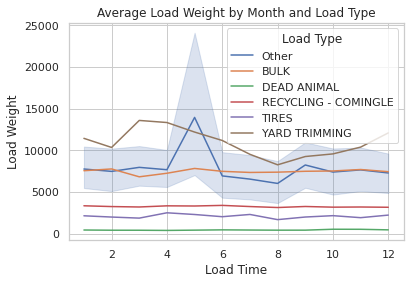

In [25]:
df_month = df_ts.groupby([df_ts.index.month, "Load Type"])["Load Weight"].mean()
df_month = pd.DataFrame(df_month)
df_month.reset_index(inplace=True)
top_5_categories = df_month["Load Type"].value_counts()[:5]
df_month["Load Type"] = [val if val in top_5_categories else "Other" for val in df_month["Load Type"]]

sns.lineplot(data=df_month, x="Load Time", y="Load Weight", hue="Load Type", ci = 95)
plt.title("Average Load Weight by Month and Load Type")

# the shaded are 2 sd's

People in Austin do a lot of yard trimming in March and April 💚 In May tire changes are due 🚘 The other major `Load Types` don't seem to depend on the time of the year.

Text(0.5, 1.0, 'Average Load Weight by Day and Load Type')

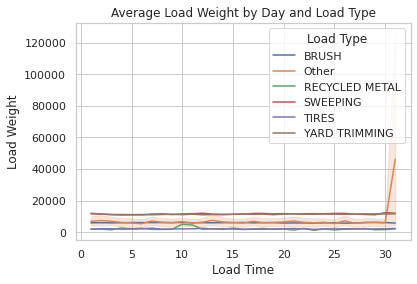

In [26]:
df_day = df_ts.groupby([df_ts.index.day, "Load Type"])["Load Weight"].mean()
df_day = pd.DataFrame(df_day)
df_day.reset_index(inplace=True)
top_5_categories = df_day["Load Type"].value_counts()[:5]
df_day["Load Type"] = [val if val in top_5_categories else "Other" for val in df_day["Load Type"]]

sns.lineplot(data=df_day, x="Load Time", y="Load Weight", hue="Load Type")
plt.title("Average Load Weight by Day and Load Type")

Surprisingly, there is only one peak in the end of the month if we look at our created `Other` category. 😯

Text(0.5, 1.0, 'Average Load Weight by Day of the Week and Load Type')

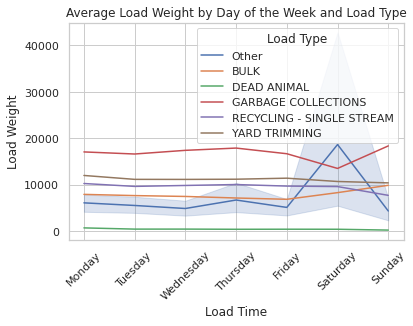

In [27]:
df_dayofweek = df_ts.groupby([df_ts.index.dayofweek, "Load Type"])["Load Weight"].mean()
df_dayofweek = pd.DataFrame(df_dayofweek)
df_dayofweek.reset_index(inplace=True)
top_5_categories = df_dayofweek["Load Type"].value_counts()[:5]
df_dayofweek["Load Type"] = [val if val in top_5_categories else "Other" for val in df_dayofweek["Load Type"]]

fig, ax = plt.subplots()
sns.lineplot(data=df_dayofweek, x = "Load Time", y="Load Weight", hue="Load Type", ax = ax)
labels = [None, 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax.set_xticklabels(labels, rotation = 45)

plt.title("Average Load Weight by Day of the Week and Load Type")

`Other` weight loads seem to be higher on Saturdays. That seems intuitive - most people work during the week and get their chores done on Saturday and Sunday ⛑

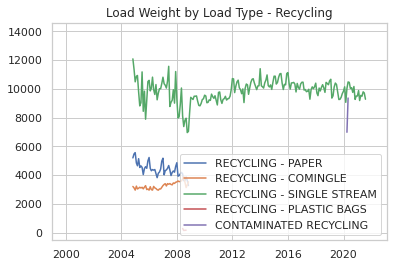

In [28]:
for load_type in [val for val in df_ts["Load Type"].unique() if "RECYCLING" in val]:
  tmp = df_ts[df_ts["Load Type"] == load_type]["Load Weight"].resample('M').mean()
  plt.plot(tmp.index, tmp.values, label=load_type)
plt.title("Load Weight by Load Type - Recycling")
plt.legend()

Recycling loads don't seem to have increased over the years. Which is surprising due to the increasing importance of climate change 🌳 Additionally, there doesn't seem to be a lot of data for the categories `RECYCLING - COMINGLE` and `RECYCLING - PAPER`.

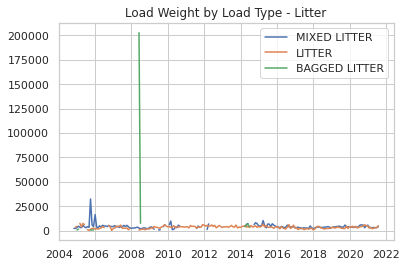

In [29]:
for load_type in [val for val in df_ts["Load Type"].unique() if "LITTER" in val]:
  tmp = df_ts[df_ts["Load Type"] == load_type]["Load Weight"].resample('M').mean()
  plt.plot(tmp.index, tmp.values, label=load_type)
plt.title("Load Weight by Load Type - Litter")
plt.legend()

What happended in 2008? Appears like there was a huge bag of litter delivered... 🗑


This plot shows clearly that we have to do outlier detection before moving onto the modelling step. Let's get the distribution of the Load Weight and see if we can draw any conclusions.

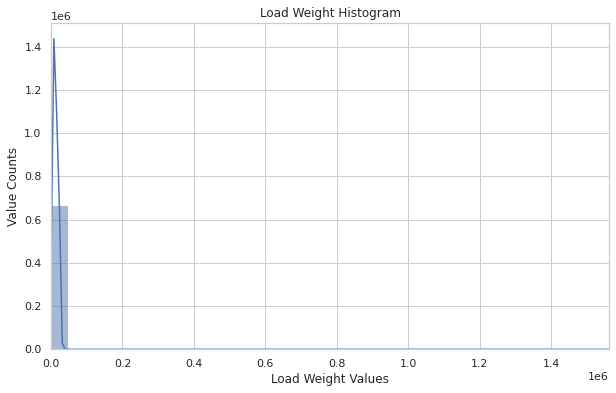

In [30]:
fig, ax = plt.subplots(1,1, figsize = (10, 6))

g = sns.histplot(df['Load Weight'], ax = ax, bins = 'doane', kde = True)
ax.set_title('Load Weight Histogram')
ax.set_xlabel('Load Weight Values')
ax.set_ylabel('Value Counts')
g.set(ylim = (0, None))
g.set(xlim = (0, df['Load Weight'].max()))

plt.show()

Well, this is terrible. Although it's hard to spot, if you pay attention to the KDE, you can see that we have many low weight records, but some values are so big that the overall histogram of the target variable can be displayed in a single bar. This basically tells us that we will have to do an outlier detection on a load type basis.

Referring to our "Load Type" vs "Load Weight" boxplot, we can see that the distribution of our target variable changes drastically with the type of the load. Most distributions are heavily skewed. In cases like these, since the distribution is not symmetrical around the mean, z-scores do not mean much. We need a more robust outlier detection algorithm. To this end, we will use medcouple on our target variable (on a load type basis). Let's show that our target variable is non-normal distributed before we move on to the outlier detection step.

In [31]:
stat, pvalue = stats.kstest(df['Load Weight'], 'norm', N = len(df['Load Weight']))

pvalue

0.0

H0 := the data is sampled from a normal distribution

Ha := the data is sampled from a non-normal distribution

We can safely reject the H0. Let's have a look at the outliers.

We will write a simple algorithm borrowed from this paper:

Hubert, M. and Vandervieren, E. (2008). An adjusted boxplot for skewed distributions. Comput. Stat. Data Anal., 52(12):5186–5201.

In [32]:
%pip install robustats

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for robustats: filename=robustats-0.1.7-cp37-cp37m-linux_x86_64.whl size=35303 sha256=db999cb67f71f4871e5575a88fe8458b3cd297e63e3731d11824e7954e791ffb
  Stored in directory: /root/.cache/pip/wheels/e8/07/c2/613b14736bee17d911bf5a6347e58482d60d890a7295a77d76
Successfully built robustats


In [33]:
df.shape

(668537, 8)

In [34]:
import robustats

for loadtype in df['Load Type'].unique(): 
  dummy = df.loc[df['Load Type'] == loadtype] # isolate that load type in the df
  medcouple = robustats.medcouple(dummy['Load Weight'].to_numpy())
  Q1 = dummy['Load Weight'].quantile(0.25)
  Q3 = dummy['Load Weight'].quantile(0.75)
  IQR = Q3 - Q1 
  iqr15 = 1.5 * IQR

  # two types of load only have on occurence, exclude them (CONTAMINATED YARD TRIMMINGS, CONTAMINATED ORGANICS)
  if dummy.shape[0] > 1:
    if (medcouple >= 0): 
      outlier_list_col = dummy[(dummy['Load Weight'] < Q1 - iqr15*math.exp(-3.5*medcouple)) | (dummy['Load Weight'] > Q3 + iqr15*math.exp(4*medcouple) )].index
    else:
      outlier_list_col = dummy[(dummy['Load Weight'] < Q1 - iqr15*math.exp(-4*medcouple)) | (dummy['Load Weight'] > Q3 + iqr15*math.exp(3.5*medcouple) )].index
    
  else: continue

  df = df.drop(outlier_list_col, axis = 0)
  print(f" - {loadtype} - Done, Medcouple: {round(medcouple, 3)}, dropped {outlier_list_col.shape[0]} rows")

 - BULK - Done, Medcouple: 0.19, dropped 69 rows
 - RECYCLING - SINGLE STREAM - Done, Medcouple: -0.291, dropped 7359 rows
 - SWEEPING - Done, Medcouple: 0.152, dropped 91 rows
 - GARBAGE COLLECTIONS - Done, Medcouple: -0.121, dropped 358 rows
 - YARD TRIMMING - Done, Medcouple: -0.03, dropped 81 rows
 - BRUSH - Done, Medcouple: 0.242, dropped 1290 rows
 - ORGANICS - Done, Medcouple: 0.065, dropped 5 rows
 - MIXED LITTER - Done, Medcouple: 0.066, dropped 40 rows
 - RECYCLED METAL - Done, Medcouple: 0.219, dropped 33 rows
 - TIRES - Done, Medcouple: 0.195, dropped 37 rows
 - DEAD ANIMAL - Done, Medcouple: 0.487, dropped 7 rows
 - RECYCLING - COMINGLE - Done, Medcouple: -0.069, dropped 294 rows
 - RECYCLING - PAPER - Done, Medcouple: 0.079, dropped 21 rows
 - LITTER - Done, Medcouple: 0.034, dropped 44 rows
 - BAGGED LITTER - Done, Medcouple: 0.012, dropped 2 rows
 - MULCH - Done, Medcouple: 0.402, dropped 126 rows
 - MATTRESS - Done, Medcouple: 0.681, dropped 1 rows
 - RECYCLING - PLAST

In [35]:
df.shape

(658679, 8)

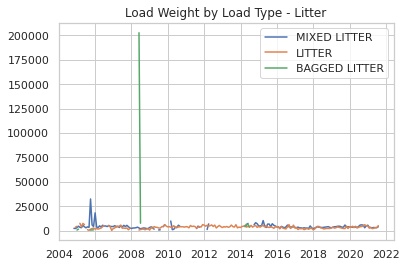

In [36]:
df_ts = df.copy()
df_ts["Load Time"] = pd.to_datetime(df_ts["Load Time"])
df_ts = df_ts.sort_values("Load Time")
df_ts.set_index("Load Time", inplace=True)
df_ts.head()

for load_type in [val for val in df_ts["Load Type"].unique() if "LITTER" in val]:
  tmp = df_ts[df_ts["Load Type"] == load_type]["Load Weight"].resample('M').mean()
  plt.plot(tmp.index, tmp.values, label=load_type)
plt.title("Load Weight by Load Type - Litter")
plt.legend()

# 2. Modelling 😃

In [37]:
%pip install category_encoders

     |████████████████████████████████| 86 kB 4.1 MB/s 


In [38]:
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_squared_error
)
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Preperation

In [39]:
cat_cols = ["Load Type", "Dropoff Site", "Route Type", "Route Number"]
# numerical features will be created during data prep
num_cols = [
    "Report Date Month", "Report Date Day", "Report Date Weekday",
    "Load Time Month", "Load Time Day", "Load Time Weekday", "Load Time Hour"
]
target_col = "Load Weight"

df_input = df.copy()

df_input["Report Date"] = pd.to_datetime(df_input["Report Date"])
df_input["Load Time"] = pd.to_datetime(df_input["Load Time"])
df_input["Report Date Month"] = df_input["Report Date"].dt.month
df_input["Report Date Day"] = df_input["Report Date"].dt.day
df_input["Report Date Weekday"] = df_input["Report Date"].dt.dayofweek
df_input["Load Time Month"] = df_input["Load Time"].dt.month
df_input["Load Time Day"] = df_input["Load Time"].dt.day
df_input["Load Time Weekday"] = df_input["Load Time"].dt.dayofweek
df_input["Load Time Hour"] = df_input["Load Time"].dt.hour

df_input = df_input.loc[:, cat_cols + num_cols + [target_col]]

# We group rare categories into an Other group in order to make our model more robust
for col in cat_cols:
    top_10_categories = df_input[col].value_counts()[:10]
    cat_column_transformed = [val if val in top_10_categories else "Other" for val in df_input[col]]
    df_input[col] = cat_column_transformed

In [58]:
# Create training and test set
X, y = df_input.loc[: , cat_cols + num_cols], list(df_input.loc[:, target_col])
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Training

In [59]:
random_state = 0
categorical_transformer = Pipeline(steps=[
      ("encoder", TargetEncoder()),
])
numeric_transformer = Pipeline(steps=[
      ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
   transformers=[
      ("categorical", categorical_transformer, cat_cols),
      ("numeric", numeric_transformer, num_cols)
]) 

Let's train a linreg before moving onto a more complex model.

In [60]:
model_algorithm = LinearRegression()
model = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("regressor", model_algorithm)
    ]
)

In [61]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   TargetEncoder())]),
                                                  ['Load Type', 'Dropoff Site',
                                                   'Route Type',
                                                   'Route Number']),
                                                 ('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Report Date Month',
                                                   'Report Date Day',
                                                   'Report Date Weekday',
                                                   'Load Time Month',
           

In [62]:
predictions = model.predict(X_test)
print(f"R2: {r2_score(y_test, predictions)}")
print(f"MAE: {mean_absolute_error(y_test, predictions)}")
print(f"MSE: {mean_squared_error(y_test, predictions)}")

R2: 0.4311173286347688
MAE: 4098.738542407423
MSE: 30513071.033773262


Not off to a bad start. Let's see if we can't improve our scores.

In [63]:
model_algorithm = XGBRegressor(random_state=random_state)
model = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("regressor", model_algorithm)
    ]
)

In [64]:
model.fit(X_train, y_train)

[11:06:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   TargetEncoder())]),
                                                  ['Load Type', 'Dropoff Site',
                                                   'Route Type',
                                                   'Route Number']),
                                                 ('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Report Date Month',
                                                   'Report Date Day',
                                                   'Report Date Weekday',
                                                   'Load Time Month',
           

In [65]:
predictions = model.predict(X_test)
print(f"R2: {r2_score(y_test, predictions)}")
print(f"MAE: {mean_absolute_error(y_test, predictions)}")
print(f"MSE: {mean_squared_error(y_test, predictions)}")

R2: 0.46666999470901704
MAE: 3869.7567645319596
MSE: 28606138.233798616


## Tuning

In [66]:
params = {
  "regressor__learning_rate": np.arange(0.1, 0.4, 0.05),
  "regressor__max_depth": np.arange(2, 10, 2),
  "regressor__min_child_weight": [1, 3, 5],
  "regressor__subsample": [0.2, 0.5, 0.7],
  "regressor__gamma": np.arange(0, 0.4, 0.1),
  "regressor__colsample_bytree": [0.5, 0.7],
  "regressor__n_estimators" : [50, 100, 200, 300, 400, 500, 1000],
  "regressor__objective": ["reg:squarederror"]
}

In [67]:
randomized_search =  RandomizedSearchCV(
    model, params, n_iter=100, n_jobs=-1, verbose=2, cv=5,
    scoring="neg_mean_absolute_error", random_state=random_state
)

In [68]:
randomized_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: ignored

We had to skip this step for today (24.03.2022) due to time constraints. We will go with single split results.

In [ ]:
print(randomized_search.best_params_)

In [ ]:
tuned_model = randomized_search.best_estimator_

In [ ]:
predictions = tuned_model.predict(X_test)
print(f"R2: {r2_score(y_test, predictions)}")
print(f"MAE: {mean_absolute_error(y_test, predictions)}")
print(f"MSE: {mean_squared_error(y_test, predictions)}")

In [ ]:
# Save model
filename = "drive/MyDrive/xgboost.pkl"
pickle.dump(model, open(filename, "wb"))

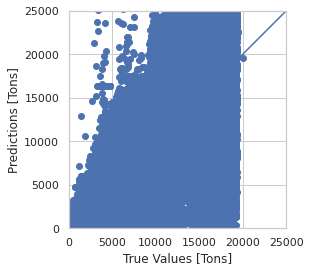

In [73]:
a = plt.axes(aspect = 'equal') 
plt.scatter(model.predict(X_test), y_test) 

plt.xlabel('True Values [Tons]')
plt.ylabel('Predictions [Tons]')

lims = [0, 25000]
plt.xlim(lims)
plt.ylim(lims)

_ = plt.plot(lims, lims)

It is clear to us that the XGB Regressor in its current iteration is not complex enough the capture the complexities of the data. We are currently in the underfitting range and we need a more complex model (and better hyperparameter tuned). Let's have a look at our residuals before moving onto interpreting the model.

In [74]:
res = model.predict(X_test) - y_test

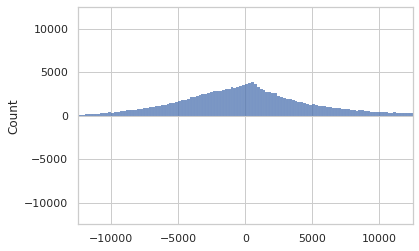

In [83]:
sns.histplot(res)

lims = [-12500, 12500]
plt.xlim(lims)
plt.ylim(lims)
plt.show()

We would have liked this plot to be a bit skinnier and not have such a wide scale. Given the underfitting behaviour of the model, we cannot say that we are surprised by the fact that we have many big errors. However, the high count of smaller errors and the shape of our histogram makes a finely tuned model promising.

# 3. Interpretability

---

SOME TEXT HERE

## Permutation Importance


In [ ]:
# Reload model
model = pickle.load(open(filename, "rb"))

[18:29:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=random_state)

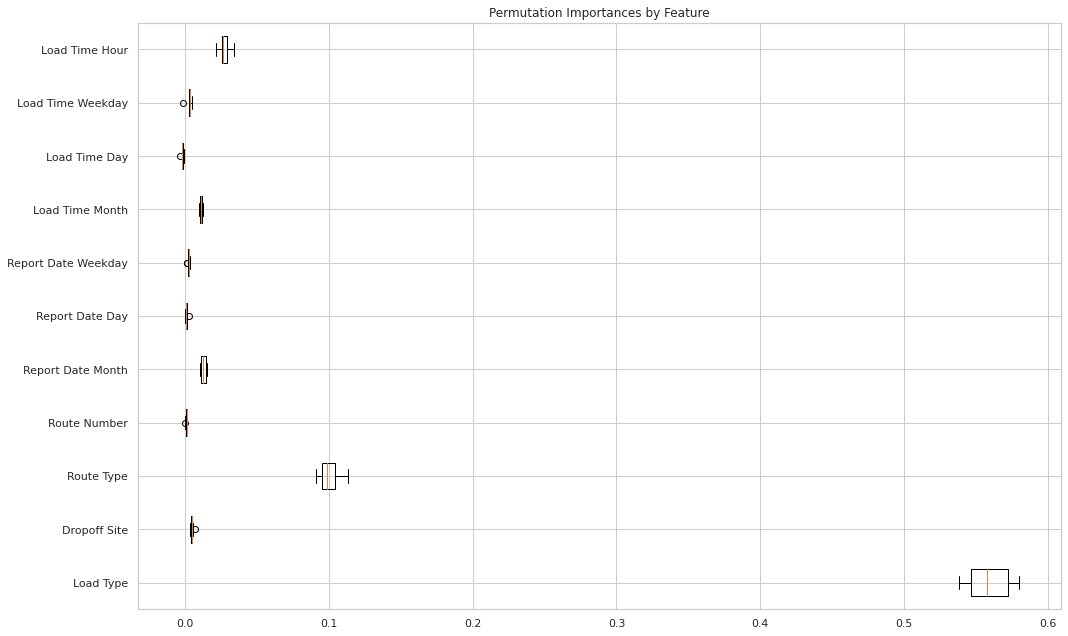

In [ ]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.boxplot(result.importances.T,vert=False, labels=X_test.columns)
ax.set_title("Permutation Importances by Feature")
fig.tight_layout()
plt.show()

SOME INTERPRETATIONS HERE

## Shapley Values

In [ ]:
%pip install shap

     |████████████████████████████████| 564 kB 4.9 MB/s 


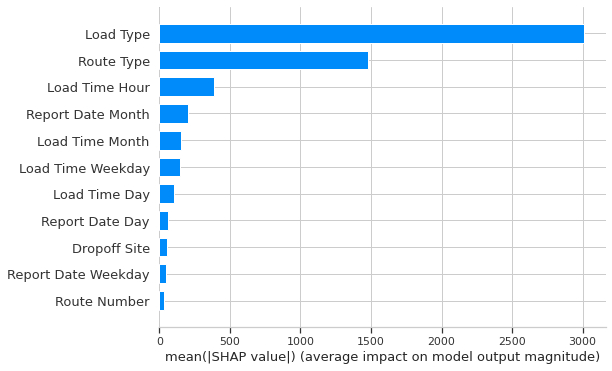

In [ ]:
import shap

# Fit the preprocessor 
X_test_transformed = pd.DataFrame(
    model['preprocessor'].transform(X_test),
    columns=X_test.columns
)

# Calculate the Shap values
shap_values = shap.TreeExplainer(model.steps[-1][1]).shap_values(X_test_transformed)

# Plot the Shap values
shap.summary_plot(shap_values, X_test_transformed, plot_type="bar")

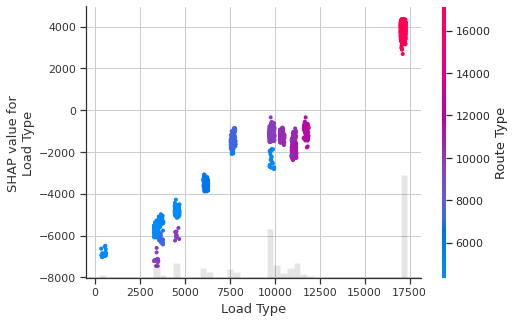

In [ ]:
explainer = shap.TreeExplainer(model.steps[-1][1])
shap_values = explainer(X_test_transformed)
shap.plots.scatter(shap_values[:,"Load Type"], color=shap_values)

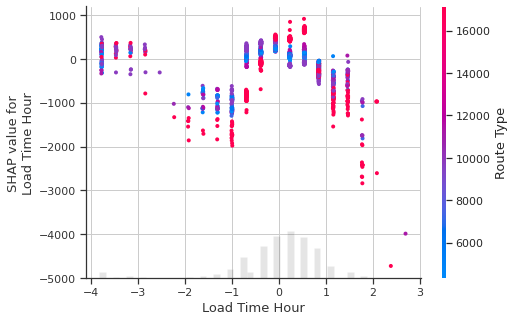

In [ ]:
shap.plots.scatter(shap_values[:,"Load Time Hour"], color=shap_values)

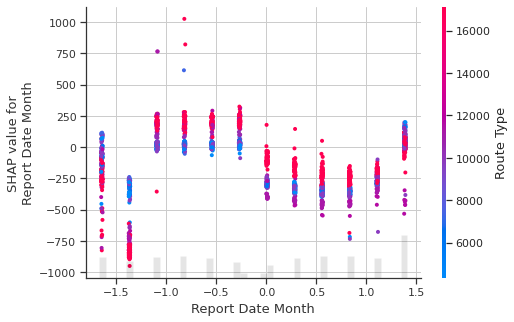

In [ ]:
shap.plots.scatter(shap_values[:,"Report Date Month"], color=shap_values)

maybe mention that report date and load time probably is correlated -> impact on feature importance metrics

also not sure if shapley plots make sense since we standardized numerical features and encoded categorical ones. After some research, this is a known issue. Haven't found a great solution yet. But probably one could fix the x-labels by reversing at least the numerical variables